Sveučilište u Zagrebu  
Fakultet elektrotehnike i računarstva  
  
## Strojno učenje 1 2021/2022
http://www.fer.unizg.hr/predmet/struce1

------------------------------

### Logistička regresija

*Verzija: 1.0 
Zadnji put ažurirano: 1. 10. 2021.*

(c) 2015-2021 Jan Šnajder, Domagoj Alagić  

Rok za predaju: **7. studenog 2021. u 23:59h**

------------------------------

### Upute

Ova laboratorijska vježba sastoji se od četiri zadatka. U nastavku slijedite upute navedene u ćelijama s tekstom. Rješavanje vježbe svodi se na **dopunjavanje ove bilježnice**: umetanja ćelije ili više njih **ispod** teksta zadatka, pisanja odgovarajućeg kôda te evaluiranja ćelija. 

Osigurajte da u potpunosti **razumijete** kôd koji ste napisali. Kod predaje vježbe, morate biti u stanju na zahtjev asistenta (ili demonstratora) preinačiti i ponovno evaluirati Vaš kôd. Nadalje, morate razumjeti teorijske osnove onoga što radite, u okvirima onoga što smo obradili na predavanju. Ispod nekih zadataka možete naći i pitanja koja služe kao smjernice za bolje razumijevanje gradiva (**nemojte pisati** odgovore na pitanja u bilježnicu). Stoga se nemojte ograničiti samo na to da riješite zadatak, nego slobodno eksperimentirajte. To upravo i jest svrha ovih vježbi.

Vježbe trebate raditi **samostalno**. Možete se konzultirati s drugima o načelnom načinu rješavanja, ali u konačnici morate sami odraditi vježbu. U protivnome vježba nema smisla.

In [589]:
# Učitaj osnovne biblioteke...
import sklearn
import matplotlib.pyplot as plt
import math
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [590]:
def plot_2d_clf_problem(X, y, h=None):
    '''
    Plots a two-dimensional labeled dataset (X,y) and, if function h(x) is given, 
    the decision surfaces.
    '''
    assert X.shape[1] == 2, "Dataset is not two-dimensional"
    if h!=None : 
        # Create a mesh to plot in
        r = 0.04  # mesh resolution
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, r),
                             np.arange(y_min, y_max, r))
        XX=np.c_[xx.ravel(), yy.ravel()]
        try:
            Z_test = h(XX)
            if Z_test.shape == ():
                # h returns a scalar when applied to a matrix; map explicitly
                Z = np.array(list(map(h,XX)))
            else :
                Z = Z_test
        except ValueError:
            # can't apply to a matrix; map explicitly
            Z = np.array(list(map(h,XX)))
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)

    # Plot the dataset
    plt.scatter(X[:,0],X[:,1], c=y, cmap=plt.cm.tab20b, marker='o', s=50)

### 1. Logistička regresija

Ovaj zadatak bavi se probabilističkim diskriminativnim modelom, **logističkom regresijom**, koja je, unatoč nazivu, klasifikacijski model.

Logistička regresija tipičan je predstavnik tzv. **poopćenih linearnih modela** koji su oblika: $h(\mathbf{x})=f(\mathbf{w}^\intercal\tilde{\mathbf{x}})$. Logistička funkcija za funkciju $f$ koristi tzv. **logističku** (sigmoidalnu) funkciju $\sigma (x) = \frac{1}{1 + \textit{exp}(-x)}$.

### (a)  

Definirajte logističku (sigmoidalnu) funkciju $\mathrm{sigm}(x)=\frac{1}{1+\exp(-\alpha x)}$ i prikažite je za $\alpha\in\{1,2,4\}$.

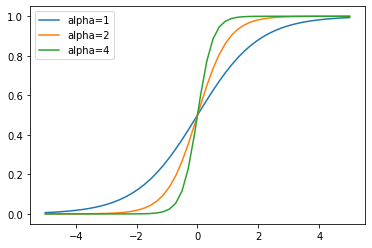

In [591]:
def sigm(x, alpha=1):
    return 1 / (1 + math.exp(-alpha * x))

for alpha in (1,2,4):
    X = np.linspace(-5, 5)
    y = []
    for x in X:
        y.append(sigm(alpha, x))
    plt.plot(X, y, label=f'alpha={alpha}')
plt.legend(loc='best')

**Q**: Zašto je sigmoidalna funkcija prikladan izbor za aktivacijsku funkciju poopćenoga linearnog modela? 
</br>

**Q**: Kakav utjecaj ima faktor $\alpha$ na oblik sigmoide? Što to znači za model logističke regresije (tj. kako izlaz modela ovisi o normi vektora težina $\mathbf{w}$)?

### (b) 

Implementirajte funkciju 

> `lr_train(X, y, eta=0.01, max_iter=2000, alpha=0, epsilon=0.0001, trace=False)` 

za treniranje modela logističke regresije gradijentnim spustom (*batch* izvedba). Funkcija uzima označeni skup primjera za učenje (matrica primjera `X` i vektor oznaka `y`) te vraća $(n+1)$-dimenzijski vektor težina tipa `ndarray`. Ako je `trace=True`, funkcija dodatno vraća listu (ili matricu) vektora težina $\mathbf{w}^0,\mathbf{w}^1,\dots,\mathbf{w}^k$ generiranih kroz sve iteracije optimizacije, od 0 do $k$. Optimizaciju treba provoditi dok se ne dosegne `max_iter` iteracija, ili kada razlika u pogrešci unakrsne entropije između dviju iteracija padne ispod vrijednosti `epsilon`. Parametar `alpha` predstavlja faktor L2-regularizacije.

Preporučamo definiranje pomoćne funkcije `lr_h(x,w)` koja daje predikciju za primjer `x` uz zadane težine `w`. Također, preporučamo i funkciju `cross_entropy_error(X,y,w)` koja izračunava pogrešku unakrsne entropije modela na označenom skupu `(X,y)` uz te iste težine.

**NB:** Obratite pozornost na to da je način kako su definirane oznake ($\{+1,-1\}$ ili $\{1,0\}$) kompatibilan s izračunom funkcije gubitka u optimizacijskome algoritmu.

In [592]:
from numpy import linalg
from sklearn.preprocessing import PolynomialFeatures

def cross_entropy_error(X, y, w):
    sum = 0
    for i in range(0, len(X)):
        calc = lr_h(X[i], w)
        sum += -y[i] * math.log(calc) - (1 - y[i]) * math.log(1 - calc)
    return sum / len(X)
    
def fi_x(x):
    model = PolynomialFeatures(len(x) - 1).fit(x.reshape(1, -1))
    return model.fit_transform(x.reshape(1, -1))[0]
    
def lr_h(x, w):
    fi_x_tilde = np.insert(fi_x(x), 0, 1)
    return sigm(fi_x_tilde.dot(w))

def lr_train(X, y, eta=0.01, max_iter=2000, alpha=0, epsilon=0.0001, trace=False):
    w = np.zeros(len(fi_x(X[0])))
    w0 = 0
    w_s = [np.insert(w, 0, w0)]
    
    iter = 1
    error = float("inf")
    error_last = float("inf")
    while iter < max_iter:
        delta_w = np.zeros((len(fi_x(X[0]))))
        delta_w0 = 0

        w_h = np.insert(w, 0, w0)
        for i in range(0, len(X)):

            h = lr_h(X[i], w_h)
            delta_w0 -= (h - y[i])
            delta_w = delta_w - (h - y[i]) * fi_x(X[i])

        w0 += eta * delta_w0
        w = w * (1 - eta * alpha) + eta * delta_w
        
        if trace == True:
            w_h = np.insert(w, 0, w0)
            w_s.append(w_h)

        error = cross_entropy_error(X, y, w_h)
        if math.fabs(error_last - error) < epsilon:
            break
        
        error_last = error
        iter += 1
        
    print(f'Training stopped on itteration #{iter}.\nError: {error}.\nWeights: {w_h}')
    w_h = np.insert(w, 0, w0)
    return (np.array(w_h), w_s)

### (c)

Koristeći funkciju `lr_train`, trenirajte model logističke regresije na skupu `seven`, prikažite dobivenu granicu između klasa te  izračunajte pogrešku unakrsne entropije. 

**NB:** Pripazite da modelu date dovoljan broj iteracija.

In [593]:
seven_X = np.array([[2,1], [2,3], [1,2], [3,2], [5,2], [5,4], [6,3]])
seven_y = np.array([1, 1, 1, 1, 0, 0, 0])

Training stopped on itteration #742.
Error: 0.09987960073356447.
Weights: [ 2.76817366  2.76817366 -1.86850935  0.52171142]


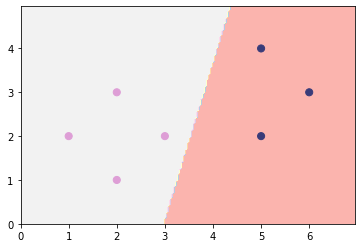

In [594]:
# Vaš kôd ovdje

final_weight, weight_history = lr_train(seven_X, seven_y, trace=True)
plot_2d_clf_problem(seven_X, seven_y, lambda x: lr_h(x, final_weight) > 0.5)


**Q:** Koji kriterij zaustavljanja je aktiviran?

**Q:** Zašto dobivena pogreška unakrsne entropije nije jednaka nuli?

**Q:** Kako biste utvrdili da je optimizacijski postupak doista pronašao hipotezu koja minimizira pogrešku učenja? O čemu to ovisi?

**Q:** Na koji način biste preinačili kôd ako biste htjeli da se optimizacija izvodi stohastičkim gradijentnim spustom (*online learning*)?

### (d)

Prikažite na jednom grafikonu pogrešku unakrsne entropije (očekivanje logističkog gubitka) i pogrešku klasifikacije (očekivanje gubitka 0-1) na skupu `seven` kroz iteracije optimizacijskog postupka. Koristite trag težina funkcije `lr_train` iz zadatka (b) (opcija `trace=True`). Na drugom grafikonu prikažite pogrešku unakrsne entropije kao funkciju broja iteracija za različite stope učenja, $\eta\in\{0.005,0.01,0.05,0.1\}$.

In [595]:
from sklearn.metrics import zero_one_loss

Training stopped on itteration #948.
Error: 0.13772930705119937.
Weights: [ 2.20265536  2.20265536 -1.6204597   0.57826241]
Training stopped on itteration #742.
Error: 0.09987960073356447.
Weights: [ 2.76817366  2.76817366 -1.86850935  0.52171142]
Training stopped on itteration #386.
Error: 0.047165995307571755.
Weights: [ 4.14625447  4.14625447 -2.46412412  0.37836029]
Training stopped on itteration #283.
Error: 0.0338635457507223.
Weights: [ 4.77562547  4.77562547 -2.74652004  0.32984724]


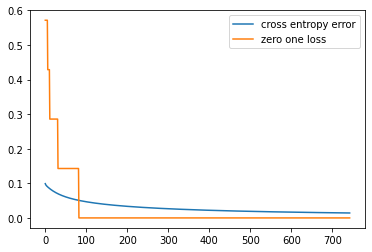

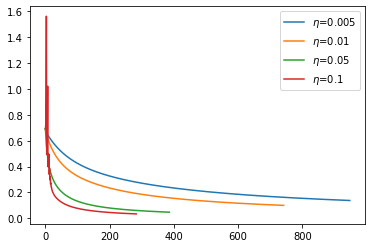

In [596]:
# Vaš kôd ovdje
figure_zero_one = plt.figure()

errors = [cross_entropy_error(seven_X, seven_y, weight_history[x]) / len(seven_X) for x in range(0, len(weight_history))]
plt.plot(errors, label='cross entropy error')
zero_one = []   
for w in weight_history:
    pred = [lr_h(x, w) > 0.5 for x in seven_X]
    zero_one.append(zero_one_loss(seven_y, pred))
plt.plot(zero_one, label='zero one loss')
plt.legend(loc='best')

figure_error = plt.figure()
for eta in (0.005, 0.01, 0.05, 0.1):
    final_weight, history_weights = lr_train(seven_X, seven_y, eta=eta, trace=True)
    errors = [cross_entropy_error(seven_X, seven_y, history_weights[x]) for x in range(0, len(history_weights))]
    plt.plot(range(0, len(errors)), errors, label=f'$\eta$={eta}')
plt.legend(loc='best')


**Q:** Zašto je pogreška unakrsne entropije veća od pogreške klasifikacije? Je li to uvijek slučaj kod logističke regresije i zašto?

**Q:** Koju stopu učenja $\eta$ biste odabrali i zašto?

### (e)

Upoznajte se s klasom [`linear_model.LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) koja implementira logističku regresiju. Usporedite rezultat modela na skupu `seven` s rezultatom koji dobivate pomoću vlastite implementacije algoritma.

**NB:** Kako ugrađena implementacija koristi naprednije verzije optimizacije funkcije, vrlo je vjerojatno da Vam se rješenja neće poklapati, ali generalne performanse modela bi trebale. Ponovno, pripazite na broj iteracija i snagu regularizacije.

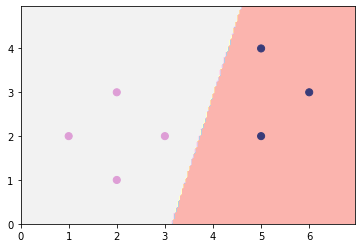

In [597]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression('none', tol=0.0001, max_iter=2000).fit(seven_X, seven_y)
plot_2d_clf_problem(seven_X, seven_y, lambda x: log_reg.predict(x) > 0.5)

### 2. Analiza logističke regresije

### (a)

Koristeći ugrađenu implementaciju logističke regresije, provjerite kako se logistička regresija nosi s vrijednostima koje odskaču. Iskoristite skup `outlier`. Prikažite granicu između klasa.

In [598]:
outlier_X = np.append(seven_X, [[12,8]], axis=0)
outlier_y = np.append(seven_y, 0)

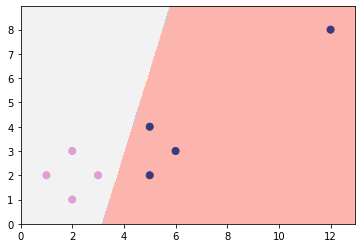

In [599]:
# Vaš kôd ovdje
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression('none', tol=0.0001, max_iter=2000).fit(seven_X, seven_y)
plot_2d_clf_problem(outlier_X, outlier_y, lambda x: log_reg.predict(x) > 0.5)

**Q:** Zašto se rezultat razlikuje od onog koji je dobio model klasifikacije linearnom regresijom iz prvog zadatka?

### (b)

Trenirajte model logističke regresije na skupu `seven` te na dva odvojena grafikona prikažite, kroz iteracije optimizacijskoga algoritma, (1) izlaz modela $h(\mathbf{x})$ za svih sedam primjera te (2) vrijednosti težina $w_0$, $w_1$, $w_2$.

Training stopped on itteration #742.
Error: 0.09987960073356447.
Weights: [ 2.76817366  2.76817366 -1.86850935  0.52171142]


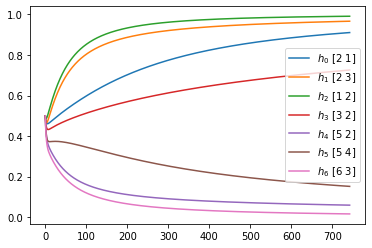

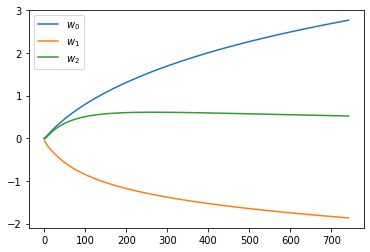

In [600]:
# Vaš kôd ovdje
final_weight, weight_history = lr_train(seven_X, seven_y, trace=True)

h_s = []
for i in range(0, len(seven_X)):
    h_s.append([])

figure_h = plt.figure()
for weight in weight_history:
    for i in range(0, len(seven_X)):
        h_s[i].append(lr_h(seven_X[i], weight))

for i in range(0, len(seven_X)):
    plt.plot(h_s[i], label=f'$h_{i}$ {seven_X[i]}')
plt.legend(loc='best')

figure_w = plt.figure()
w0 = []
w1 = []
w2 = []
for w in weight_history:
    w0.append(w[1])
    w1.append(w[2])
    w2.append(w[3])
plt.plot(w0, label=f'$w_0$')
plt.plot(w1, label=f'$w_1$')
plt.plot(w2, label=f'$w_2$')
plt.legend(loc='best')


### (c)

Ponovite eksperiment iz podzadatka (b) koristeći linearno neodvojiv skup podataka `unsep`.

In [601]:
unsep_X = np.append(seven_X, [[2,2]], axis=0)
unsep_y = np.append(seven_y, 0)

Training stopped on itteration #339.
Error: 0.38976336186854854.
Weights: [ 1.31335203  1.31335203 -1.11879116  0.30129974]


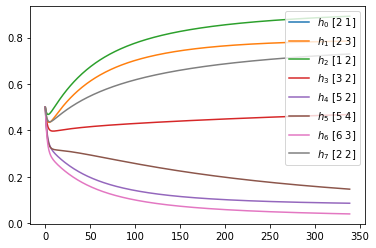

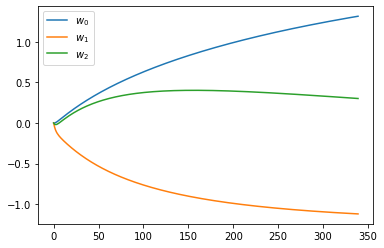

In [602]:
# Vaš kôd ovdje
final_weight, weight_history = lr_train(unsep_X, unsep_y, trace=True)

h_s = []
for i in range(0, len(unsep_X)):
    h_s.append([])

figure_h = plt.figure()
for weight in weight_history:
    for i in range(1, len(unsep_X)):
        h_s[i].append(lr_h(unsep_X[i], weight))

for i in range(0, len(unsep_X)):
    plt.plot(h_s[i], label=f'$h_{i}$ {unsep_X[i]}')
plt.legend(loc='best')

figure_w = plt.figure()
w0 = []
w1 = []
w2 = []
for w in weight_history:
    w0.append(w[1])
    w1.append(w[2])
    w2.append(w[3])
plt.plot(w0, label=f'$w_0$')
plt.plot(w1, label=f'$w_1$')
plt.plot(w2, label=f'$w_2$')
plt.legend(loc='best')


**Q:** Usporedite grafikone za slučaj linearno odvojivih i linearno neodvojivih primjera te komentirajte razliku.

### 3. Regularizirana logistička regresija

Trenirajte model logističke regresije na skupu `seven` s različitim faktorima L2-regularizacije, $\alpha\in\{0,1,10,100\}$. Prikažite na dva odvojena grafikona (1) pogrešku unakrsne entropije te (2) L2-normu vektora $\mathbf{w}$ kroz iteracije optimizacijskog algoritma.

In [603]:
from numpy.linalg import norm

Training stopped on itteration #742.
Error: 0.09987960073356447.
Weights: [ 2.76817366  2.76817366 -1.86850935  0.52171142]
Training stopped on itteration #743.
Error: 0.2101291133716018.
Weights: [ 3.25746741  0.26441923 -0.94377154 -0.02725717]
Training stopped on itteration #407.
Error: 0.4335987796147006.
Weights: [ 1.60192583  0.01253358 -0.34221809 -0.08356121]
Training stopped on itteration #4.
Error: 0.6734609797191927.
Weights: [ 0.02542301  0.0066411  -0.03252526 -0.00051432]


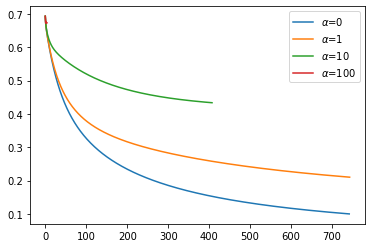

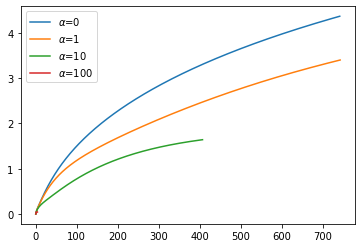

In [604]:
figure_errors = plt.figure(0)
figure_l2 = plt.figure(1)

for alpha in (0, 1, 10, 100):
    final_weights, weights_history = lr_train(seven_X, seven_y, alpha=alpha, trace=True)
    errors = []
    L2_norm = []
    for w in weights_history:
        errors.append(cross_entropy_error(seven_X, seven_y, w))
        L2_norm.append(norm(w))
    
    plt.figure(0)
    plt.plot(errors, label=f'$\\alpha$={alpha}')
    
    plt.figure(1)
    plt.plot(L2_norm, label=f'$\\alpha$={alpha}')

plt.figure(0)
plt.legend(loc='best')
plt.figure(1)
plt.legend(loc='best')
    

**Q:** Jesu li izgledi krivulja očekivani i zašto?

**Q:** Koju biste vrijednost za $\alpha$ odabrali i zašto?

### 4. Logistička regresija s funkcijom preslikavanja

Proučite funkciju [`datasets.make_classification`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html). Generirajte i prikažite dvoklasan skup podataka s ukupno $N=100$ dvodimenzijskih ($n=2)$ primjera, i to sa dvije grupe po klasi (`n_clusters_per_class=2`). Malo je izgledno da će tako generiran skup biti linearno odvojiv, međutim to nije problem jer primjere možemo preslikati u višedimenzijski prostor značajki pomoću klase [`preprocessing.PolynomialFeatures`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html), kao što smo to učinili kod linearne regresije u prvoj laboratorijskoj vježbi. Trenirajte model logističke regresije koristeći za preslikavanje u prostor značajki polinomijalnu funkciju stupnja $d=2$ i stupnja $d=3$. Prikažite dobivene granice između klasa. Možete koristiti svoju implementaciju, ali se radi brzine preporuča koristiti `linear_model.LogisticRegression`. Regularizacijski faktor odaberite po želji.

**NB:** Kao i ranije, za prikaz granice između klasa koristite funkciju `plot_2d_clf_problem`. Funkciji kao argumente predajte izvorni skup podataka, a preslikavanje u prostor značajki napravite unutar poziva funkcije `h` koja čini predikciju, na sljedeći način:

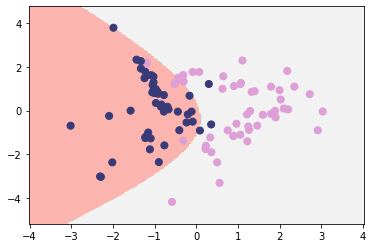

In [605]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.datasets import make_classification

set_X, set_y = make_classification(n_samples=100, n_redundant=0, n_features=2, n_clusters_per_class=2)
poly_2 = PolynomialFeatures(2)
design_matrix = poly_2.fit_transform(set_X)
model = LogisticRegression().fit(design_matrix, set_y)
plot_2d_clf_problem(set_X, set_y, lambda x : model.predict(poly_2.transform(x)))

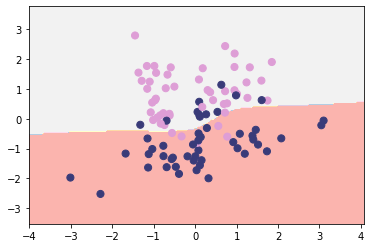

In [606]:
set_X, set_y = make_classification(n_samples=100, n_redundant=0, n_features=2, n_clusters_per_class=2)
poly_3 = PolynomialFeatures(3)
design_matrix = poly_3.fit_transform(set_X)
model = LogisticRegression().fit(design_matrix, set_y)
plot_2d_clf_problem(set_X, set_y, lambda x : model.predict(poly_3.transform(x)))

**Q:** Koji biste stupanj polinoma upotrijebili i zašto? Je li taj odabir povezan s odabirom regularizacijskog faktora $\alpha$? Zašto?